In this notebook:

- **Feature Engineering:**

    - New numerical features were created by combining existing numerical features.

    - Right-skewed numerical features were transformed to reduce skew, which may improve Logistic Regression performance.

    - New categorical features were derived from numerical features, which may enhance the performance of tree-based models.

- **Model Evaluation**

    - All models were retrained, and their performance was evaluated using the same four metrics and confusion matrices.

    - Finally, the best-performing model was selected.

In [6]:
import sys
import os

PROJECT_ROOT = os.path.abspath("..")
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

### **Importing libraries**

In [7]:
from src.features_eng import feature_engineering
from src.train import train_model
from src.evaluate import evaluate_model, evaluate_train_data
from src.utils import load_data
from src.encoding import fit_and_save_label_encoder
import pandas as pd
import numpy as np

### **Feature Engineering**

In [8]:
train_data = load_data('../data/02_clean/cleaned_train_data.csv')
test_data = load_data('../data/02_clean/cleaned_test_data.csv')

train_data_fe = feature_engineering(train_data)
test_data_fe = feature_engineering(test_data)
train_data_fe

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type,Temp_Humidity_Interaction,Wind_Speed_Precipitation_Interaction,Humidity_Visibility_Interaction,UV_Index_log,Wind_Speed_log,Visibility_log,Temperature_cat,Humidity_cat,Wind_Speed_cat
0,-15.0,91,20.5,90.0,overcast,981.13,8,Winter,1.5,inland,Snowy,-1365.0,1845.0,36.400000,2.197225,3.068053,0.916291,Freezing,High,Breezy
1,39.0,62,4.5,1.0,clear,1012.17,9,Summer,9.5,mountain,Sunny,2418.0,4.5,5.904762,2.302585,1.704748,2.351375,Hot,High,Calm
2,-7.0,91,15.0,81.0,partly cloudy,988.76,1,Winter,3.5,mountain,Snowy,-637.0,1215.0,20.222222,0.693147,2.772589,1.504077,Freezing,High,Breezy
3,-8.0,76,12.5,50.0,overcast,992.61,0,Winter,3.0,inland,Snowy,-608.0,625.0,19.000000,0.000000,2.602690,1.386294,Freezing,High,Breezy
4,18.0,56,5.5,25.0,partly cloudy,1003.80,1,Winter,7.0,coastal,Cloudy,1008.0,137.5,7.000000,0.693147,1.871802,2.079442,Moderate,Medium,Calm
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5906,23.0,73,7.5,12.0,partly cloudy,1009.66,1,Winter,7.5,inland,Cloudy,1679.0,90.0,8.588235,0.693147,2.140066,2.140066,Moderate,High,Calm
5907,23.0,62,14.5,24.0,partly cloudy,1005.56,2,Autumn,5.5,inland,Cloudy,1426.0,348.0,9.538462,1.098612,2.740840,1.871802,Moderate,High,Breezy
5908,25.0,91,15.0,77.0,partly cloudy,1010.41,6,Autumn,6.0,mountain,Cloudy,2275.0,1155.0,13.000000,1.945910,2.772589,1.945910,Moderate,High,Breezy
5909,-2.0,82,3.5,89.0,overcast,983.11,1,Winter,2.5,inland,Snowy,-164.0,311.5,23.428571,0.693147,1.504077,1.252763,Freezing,High,Calm


### **Saving data**

In [9]:
train_data_fe.to_csv('../data/03_featured/featured_train_data.csv', index=False)
test_data_fe.to_csv('../data/03_featured/featured_test_data.csv', index=False)

### **Retraining and evaluating the models**

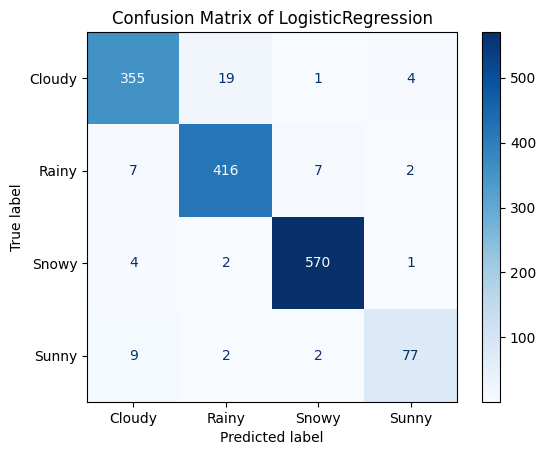

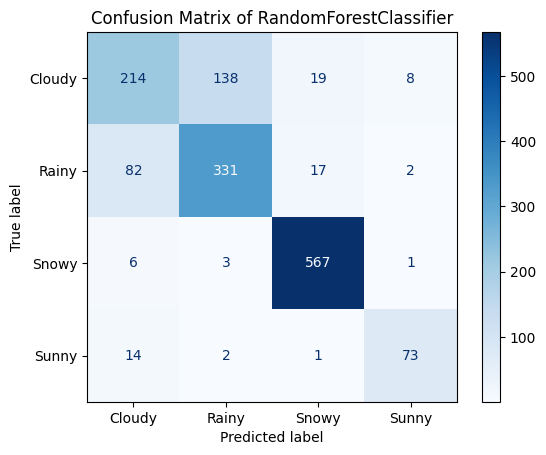

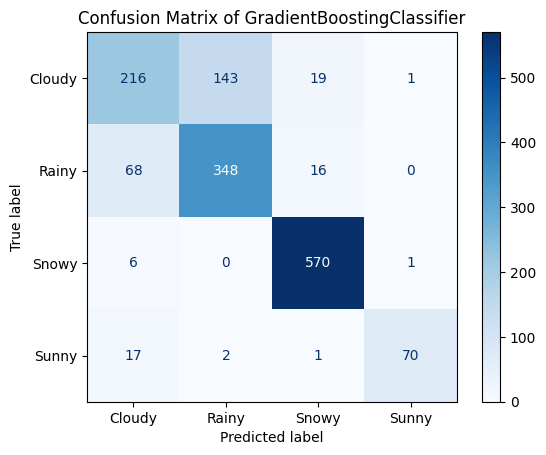

In [10]:
X_train = train_data_fe.drop(columns=['Weather Type'])
y_train = train_data_fe['Weather Type']

X_test = test_data_fe.drop(columns=['Weather Type'])
y_test = test_data_fe['Weather Type']

le = fit_and_save_label_encoder(y_train)
y_train_encoded = le.transform(y_train)
y_test_encoded = le.transform(y_test)

models = train_model(X_train, y_train_encoded)

results_rows = []

for model_name, model in models.items():

    train_scores = evaluate_train_data(model, X_train, y_train_encoded)
    
    # Just taking the first element (metrics), because the second is the confusion matrix
    test_scores = evaluate_model(model, test_data_fe, y_test_encoded, label_encoder=le)[0]

    results_rows.append({
        "model": model_name,
        "split": "train",
        **train_scores
    })

    results_rows.append({
        "model": model_name,
        "split": "test",
        **test_scores
    })

    results = pd.DataFrame(results_rows)

In [11]:
print(results)

         model  split  precision    recall  f1_score   roc_auc
0      log_reg  train   0.959728  0.959905  0.959675  0.991743
1      log_reg   test   0.959205  0.959405  0.959213  0.992187
2  rand_forest  train   0.828636  0.830486  0.828337  0.956238
3  rand_forest   test   0.797161  0.801759  0.797435  0.938231
4   grad_boost  train   0.816382  0.815936  0.813120  0.948655
5   grad_boost   test   0.813141  0.814614  0.810234  0.945585


- After retraining on the dataset, the performance of all models improved considerably. **Logistic Regression** remains the best-performing model and will therefore be selected as our final model.

In [12]:
results.to_csv('../results/02_after_feature_engineering/retraining_results.csv', index=False)